In [89]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from gymnasium import spaces
from collections import deque
from stable_baselines3.common.vec_env import DummyVecEnv
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

In [54]:
# Téléchargement des données des commodities
commodities = ['GC=F', 'SI=F', 'NG=F']

In [40]:
def get_commodities_data(tickers, start="2010-01-01", end="2023-01-01", interval="1d"):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end, interval=interval)
        data[ticker] = df
    return data

In [206]:
commodities_data = get_commodities_data(commodities)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [205]:
# Fonction de normalisation des indicateurs
def normalize_indicators(df):
    scaler = MinMaxScaler(feature_range=(0.1, 1))
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df, scaler

In [207]:
# Ajout des indicateurs techniques
def add_technical_indicators(df):
    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    df['BB_Mid'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Mid'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Mid'] - 2 * df['BB_Std']
    
    # CCI
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
    df['CCI'] = (tp - sma_tp) / (0.015 * mean_dev)
    
    # Volume
    df['Volume'] = np.log1p(df['Volume'])  # Pour aplatir les grandes valeurs
    df['Volume'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()

    df.dropna(inplace=True)
    return df

In [208]:
# Ajout des indicateurs aux données des commodities
scalers = {}
for ticker in commodities:
    commodities_data[ticker] = add_technical_indicators(commodities_data[ticker])
    commodities_data[ticker], scaler = normalize_indicators(commodities_data[ticker])  # Normalisation des indicateurs
    scalers[ticker] = scaler

==================================
Environnement personnalisé avec LSTM
==================================

In [209]:
# class CommodityTradingEnv(gym.Env):
#     metadata = {'render_modes': ['human']}

#     def __init__(self, commodity_data, transaction_cost_percent=0.002, initial_balance=100):
#         super(CommodityTradingEnv, self).__init__()

#         self.commodity_data = {ticker: df for ticker, df in commodity_data.items() if not df.empty}
#         self.tickers = list(self.commodity_data.keys())
#         if not self.tickers:
#             raise ValueError("Aucune donnée disponible pour les commodities.")

#         sample_df = next(iter(self.commodity_data.values()))
#         self.n_features = len(sample_df.columns)

#         self.action_list = [-1, -0.75, -0.50, -0.25, 0, 0.25, 0.50, 0.75, 1]
#         self.num_actions_per_commodity = len(self.action_list)
#         self.action_space = spaces.Discrete(self.num_actions_per_commodity ** len(self.tickers))

#         self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

#         self.initial_balance = initial_balance 
#         self.transaction_cost_percent = transaction_cost_percent
#         self.max_steps = max(0, min(len(df) for df in self.commodity_data.values()) - 1)
#         self.reset()

#     def reset(self, seed=None, options=None):
#         super().reset(seed=seed)
#         self.balance = self.initial_balance
#         self.net_worth = self.initial_balance
#         self.max_net_worth = self.initial_balance
#         self.shares_held = {ticker: 0 for ticker in self.tickers}
#         self.current_step = 0
#         return self._next_observation(), {}

#     def _next_observation(self):
#         frame = np.zeros(self.obs_shape)
#         idx = 0
#         for ticker in self.tickers:
#             df = self.commodity_data[ticker]
#             if self.current_step < len(df):
#                 frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
#             else:
#                 frame[idx:idx+self.n_features] = df.iloc[-1].values
#             idx += self.n_features

#         frame[-4-len(self.tickers)] = self.balance
#         frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers]
#         frame[-3] = self.net_worth
#         frame[-2] = self.max_net_worth
#         frame[-1] = self.current_step

#         return frame

#     def decode_action(self, action):
#         decoded_indices = []
#         temp = action
#         for _ in range(len(self.tickers)):
#             decoded_indices.append(temp % self.num_actions_per_commodity)
#             temp //= self.num_actions_per_commodity
#         decoded_indices.reverse()
#         return [self.action_list[idx] for idx in decoded_indices]

#     def step(self, action):
#         actions = self.decode_action(action)
#         prev_net_worth = self.net_worth
#         self.current_step += 1
#         if self.current_step > self.max_steps:
#             return self._next_observation(), 0, True, False, {}

#         penalty = 0
#         current_prices = {}
#         has_traded = False

#         for i, ticker in enumerate(self.tickers):
#             price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])
#             act = actions[i]
#             current_prices[ticker] = price

#             # Si l'action est négative et l'agent n'a pas de titres, on pénalise
#             if act < 0 and self.shares_held[ticker] <= 0:
#                 penalty -= 0.001
#                 continue

#             # Achat
#             if act > 0:
#                 # Calcul du nombre de parts à acheter en fonction du solde disponible
#                 shares_to_buy = int(self.balance * act / price)
#                 cost = shares_to_buy * price
#                 transaction_cost = cost * self.transaction_cost_percent
#                 if cost + transaction_cost <= self.balance and shares_to_buy > 0:
#                     self.balance -= (cost + transaction_cost)  # Déduit le coût de l'achat + frais de transaction
#                     self.shares_held[ticker] += shares_to_buy
#                     has_traded = True

#             # Vente
#             elif act < 0:
#                 shares_to_sell = int(self.shares_held[ticker] * abs(act))
#                 shares_to_sell = min(shares_to_sell, self.shares_held[ticker])
#                 if shares_to_sell > 0:
#                     sale = shares_to_sell * price
#                     transaction_cost = sale * self.transaction_cost_percent
#                     self.balance += (sale - transaction_cost)  # Crédité après frais de transaction
#                     self.shares_held[ticker] -= shares_to_sell

#         self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
#         reward = (self.net_worth - prev_net_worth) / (prev_net_worth + 1e-8) - penalty

#         done = self.net_worth <= 0 or self.current_step >= self.max_steps
#         return self._next_observation(), reward, done, False, {}

#     def render(self, mode='human'):
#         profit = self.net_worth - self.initial_balance
#         print(f"Step: {self.current_step}")
#         print(f"Balance: {self.balance:.2f}")
#         for ticker in self.tickers:
#             print(f"{ticker} Shares held: {self.shares_held[ticker]}")
#         print(f"Net worth: {self.net_worth:.2f} | Profit: {profit:.2f}")

class CommodityTradingEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, commodity_data, scalers, transaction_cost_percent=0.002, initial_balance=100):
        super(CommodityTradingEnv, self).__init__()

        self.commodity_data = {ticker: df for ticker, df in commodity_data.items() if not df.empty}
        self.tickers = list(self.commodity_data.keys())
        if not self.tickers:
            raise ValueError("Aucune donnée disponible pour les commodities.")

        sample_df = next(iter(self.commodity_data.values()))
        self.n_features = len(sample_df.columns)

        self.action_list = [-1, -0.75, -0.50, -0.25, 0, 0.25, 0.50, 0.75, 1]
        self.num_actions_per_commodity = len(self.action_list)
        self.action_space = spaces.Discrete(self.num_actions_per_commodity ** len(self.tickers))

        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

        self.scalers = scalers
        self.net_worth_change_pct = 0
        self.initial_balance = initial_balance  
        self.transaction_cost_percent = transaction_cost_percent
        self.max_steps = max(0, min(len(df) for df in self.commodity_data.values()) - 1)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0
        self.net_worth_change_pct = 0
        return self._next_observation(), {}

    def _next_observation(self):
        frame = np.zeros(self.obs_shape)
        idx = 0
        for ticker in self.tickers:
            df = self.commodity_data[ticker]
            if self.current_step < len(df):
                frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            else:
                frame[idx:idx+self.n_features] = df.iloc[-1].values
            idx += self.n_features

        frame[-4-len(self.tickers)] = self.balance
        frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers]
        frame[-3] = self.net_worth
        frame[-2] = self.max_net_worth
        frame[-1] = self.current_step

        return frame

    def decode_action(self, action):
        decoded_indices = []
        temp = action
        for _ in range(len(self.tickers)):
            decoded_indices.append(temp % self.num_actions_per_commodity)
            temp //= self.num_actions_per_commodity
        decoded_indices.reverse()
        return [self.action_list[idx] for idx in decoded_indices]

    def step(self, action):
        actions = self.decode_action(action)
        prev_net_worth = self.net_worth
        self.current_step += 1
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}

        penalty = 0
        current_prices = {}
        has_traded = False

        for i, ticker in enumerate(self.tickers):
            # Récupération du prix normalisé
            price_norm = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])
            act = actions[i]
            current_prices[ticker] = price_norm

            # Pénalisation si vente sans titres
            if act < 0 and self.shares_held[ticker] <= 0:
                penalty -= 0.001
                continue

            # Achat
            if act > 0:
                shares_to_buy = int(self.balance * act / price_norm)
                cost = shares_to_buy * price_norm
                transaction_cost = cost * self.transaction_cost_percent
                if cost + transaction_cost <= self.balance and shares_to_buy > 0:
                    self.balance -= (cost + transaction_cost)
                    self.shares_held[ticker] += shares_to_buy
                    has_traded = True

            # Vente
            elif act < 0:
                shares_to_sell = int(self.shares_held[ticker] * abs(act))
                shares_to_sell = min(shares_to_sell, self.shares_held[ticker])
                if shares_to_sell > 0:
                    sale = shares_to_sell * price_norm
                    transaction_cost = sale * self.transaction_cost_percent
                    self.balance += (sale - transaction_cost)
                    self.shares_held[ticker] -= shares_to_sell

        # Calcul du net_worth
        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
        self.max_net_worth = max(self.net_worth, self.max_net_worth)

        # Calcul du pourcentage d'évolution par rapport au capital initial
        self.net_worth_change_pct = (self.net_worth - self.initial_balance) / self.initial_balance * 100

        reward = (self.net_worth - prev_net_worth) / (prev_net_worth + 1e-8) - penalty

        done = self.net_worth <= 0 or self.current_step >= self.max_steps
        return self._next_observation(), reward, done, False, {}

    def render(self, mode='human'):
        profit_pct = (self.net_worth - self.initial_balance) / self.initial_balance * 100
        print(f"Step: {self.current_step}")
        print(f"Balance: {self.balance:.2f}")
        for ticker in self.tickers:
            print(f"{ticker} Shares held: {self.shares_held[ticker]}")
        print(f"Net worth: {self.net_worth:.2f} | Profit: {profit_pct:.2f}%")

==================================
Double DQN avec LSTM
==================================

In [210]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)

In [211]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(LSTMNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # On prend la dernière sortie LSTM
        out = self.fc(lstm_out)
        return out

In [212]:
class DoubleDQN:
    def __init__(self, env, learning_rate=1e-4, gamma=0.99, batch_size=32, device="cpu"):
        self.env = env
        self.device = torch.device(device)
        self.gamma = gamma
        self.batch_size = batch_size
        self.q_net = LSTMNetwork(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_net = LSTMNetwork(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer()
        self.update_target_network(hard=True)

    def update_target_network(self, hard=True):
        if hard:
            self.target_net.load_state_dict(self.q_net.state_dict())
        else:
            for target_param, param in zip(self.target_net.parameters(), self.q_net.parameters()):
                target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)

    def train_step(self):
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Double DQN Target Calculation
        next_q = self.q_net(next_states)
        next_actions = next_q.argmax(dim=1, keepdim=True)
        next_q_target = self.target_net(next_states).gather(1, next_actions)

        target_q = rewards + (1 - dones) * self.gamma * next_q_target
        current_q = self.q_net(states).gather(1, actions)
        loss = nn.MSELoss()(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def predict(self, obs):
        obs_tensor = torch.FloatTensor(obs).to(self.device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(obs_tensor)
        action = torch.argmax(q_values, dim=1).item()
        return action
    
    @classmethod
    def load(cls, path, env, device="cpu", **kwargs):
        agent = cls(env=env, device=device, **kwargs)
        agent.q_net.load_state_dict(torch.load(path, map_location=device))
        agent.update_target_network(hard=True)
        return agent

===========================
Entraînement et validation
===========================

In [213]:
# Définir les plages de temps
training_data_time_range = ('2010-01-01', '2017-12-31')
validation_data_time_range = ('2018-01-01', '2019-12-31')
test_data_time_range = ('2020-01-01', '2023-01-01')

In [214]:
# Diviser les données selon les plages de temps
training_data = {ticker: df.loc[training_data_time_range[0]:training_data_time_range[1]] for ticker, df in commodities_data.items()}
validation_data = {ticker: df.loc[validation_data_time_range[0]:validation_data_time_range[1]] for ticker, df in commodities_data.items()}
test_data = {ticker: df.loc[test_data_time_range[0]:test_data_time_range[1]] for ticker, df in commodities_data.items()}

In [215]:
# Créer l'environnement avec les données de formation
env_train = DummyVecEnv([lambda: CommodityTradingEnv(training_data, scalers=scalers)])
env_val = DummyVecEnv([lambda: CommodityTradingEnv(validation_data, scalers=scalers)])
env_test = DummyVecEnv([lambda: CommodityTradingEnv(test_data, scalers=scalers)])

In [216]:
# Créer et entraîner le modèle
model = DoubleDQN(env_train, device="cpu", batch_size=32)
best_val_reward = -np.inf
best_model_path = "best_model.pth"

In [65]:
# Stratégie d'entraînement
num_epochs = 30
timesteps_per_epoch = 1000

In [66]:
train_losses = []
train_rewards = []
val_rewards = []

In [217]:
for epoch in tqdm(range(num_epochs)):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    
    # Entraînement
    epoch_reward = 0
    epoch_loss = 0
    obs = env_train.reset()
    done = False

    for step in range(timesteps_per_epoch):
        epsilon = max(0.05, 1.0 - (epoch * timesteps_per_epoch + step) / 50000)
        if np.random.rand() < epsilon:
            action = env_train.action_space.sample()
        else:
            action = model.predict(obs)

        next_obs, reward, done, _ = env_train.step([action])
        env_train.render()
        model.replay_buffer.push(obs, action, reward, next_obs, done)
        obs = next_obs
        epoch_reward += reward 

        if len(model.replay_buffer) > 1000:
            loss = model.train_step()
            epoch_loss += loss

        if done:
            obs = env_train.reset()

    avg_loss = epoch_loss / timesteps_per_epoch if epoch_loss > 0 else 0.0
    epoch_reward = epoch_reward.item()
    train_losses.append(avg_loss)
    train_rewards.append(epoch_reward)

    
    print(f"Train Reward: {epoch_reward:.2f} | Train Loss: {avg_loss:.4f}")

    # Validation
    val_reward = 0
    obs_val = env_val.reset()
    done = False

    while not done:
        action = model.predict(obs_val)
        obs_val, reward, done, _ = env_val.step([action])
        val_reward += reward

    val_reward = val_reward.item()
    val_rewards.append(val_reward)
    print(f"Validation Reward: {val_reward:.2f}")

    # Sauvegarder le meilleur modèle
    if val_reward > best_val_reward:
        best_val_reward = val_reward
        torch.save(model.q_net.state_dict(), best_model_path)
        print(f"Meilleur modèle sauvegardé avec reward = {best_val_reward:.2f}")

  0%|          | 0/30 [00:00<?, ?it/s]


=== Epoch 1/30 ===


C:\Users\planc\AppData\Local\Temp\ipykernel_13672\3871715114.py:199: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_norm = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])
d:\Developpement\Miniconda\envs\env_rl_project\Lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:259: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Train Reward: -0.13 | Train Loss: 0.0000
Validation Reward: 0.30
Meilleur modèle sauvegardé avec reward = 0.30

=== Epoch 2/30 ===


d:\Developpement\Miniconda\envs\env_rl_project\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 32, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Reward: -0.78 | Train Loss: 0.1869
Validation Reward: 0.38
Meilleur modèle sauvegardé avec reward = 0.38

=== Epoch 3/30 ===
Train Reward: 0.44 | Train Loss: 0.0360
Validation Reward: 0.78
Meilleur modèle sauvegardé avec reward = 0.78

=== Epoch 4/30 ===
Train Reward: -0.27 | Train Loss: 0.0426
Validation Reward: 0.15

=== Epoch 5/30 ===
Train Reward: -0.15 | Train Loss: 0.0441
Validation Reward: 0.79
Meilleur modèle sauvegardé avec reward = 0.79

=== Epoch 6/30 ===
Train Reward: -0.10 | Train Loss: 0.0553
Validation Reward: 0.70

=== Epoch 7/30 ===
Train Reward: -0.44 | Train Loss: 0.0602
Validation Reward: 0.50

=== Epoch 8/30 ===
Train Reward: -0.58 | Train Loss: 0.0591
Validation Reward: 0.41

=== Epoch 9/30 ===
Train Reward: 0.91 | Train Loss: 0.0548
Validation Reward: 0.06

=== Epoch 10/30 ===
Train Reward: -0.39 | Train Loss: 0.0452
Validation Reward: 0.36

=== Epoch 11/30 ===
Train Reward: 0.11 | Train Loss: 0.0515
Validation Reward: 0.29

=== Epoch 12/30 ===
Train Reward

In [218]:
# Charger et tester le meilleur modèle
model = DoubleDQN.load(best_model_path, env=env_test, device="cpu")
# Tester le modèle sur le set de test
env_test = DummyVecEnv([lambda: CommodityTradingEnv(test_data, scalers)])
test_rewards = []
test_cumulative_reward = 0
obs_test = env_test.reset()
done = False

In [219]:
while not done:
    action = model.predict(obs_test)
    obs_test, reward, done, _ = env_test.step([action])
    reward = reward.item()
    test_rewards.append(reward)
    test_cumulative_reward += reward

C:\Users\planc\AppData\Local\Temp\ipykernel_13672\3871715114.py:199: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_norm = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])


In [220]:
print(f"Test Cumulative Reward: {test_cumulative_reward:.2f}")

Test Cumulative Reward: 1.57


===========================
Visualisation des performances
===========================

In [221]:
def plot_reward_distribution(rewards):
    plt.figure(figsize=(10, 6))
    plt.hist(rewards, bins=100, color='skyblue', edgecolor='black')
    plt.title("Distribution des récompenses sur le set de test")
    plt.xlabel("Récompense")
    plt.ylabel("Fréquence")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

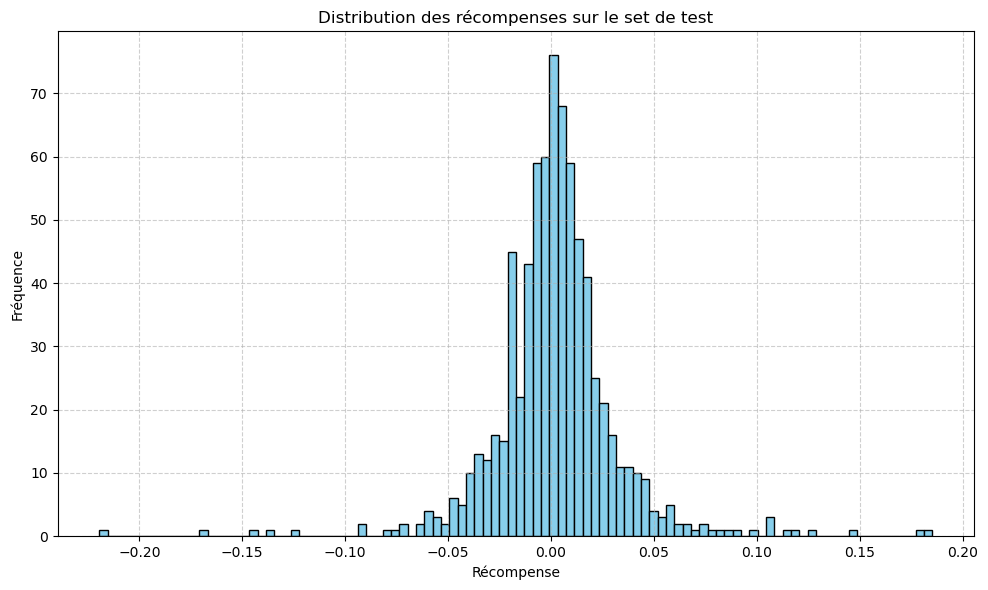

In [222]:
# Visualisation des récompenses de test
plot_reward_distribution(test_rewards)

===========================
Visualisation des courbes de train loss
===========================

In [223]:
def plot_losses(epochs, train_losses):
    """
    Trace les courbes de pertes (loss) d'entraînement en fonction des epochs.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

===========================
Visualisation des courbes de récompenses
===========================

In [224]:
def plot_rewards(epochs, train_rewards, val_rewards):
    """
    Trace les courbes de récompenses (train & validation) en fonction des epochs.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_rewards, label='Train Reward', color='blue')
    plt.plot(epochs, val_rewards, label='Validation Reward', color='orange')
    plt.title("Train & Validation Reward per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

===========================
Visualisation de la stratégie de trading sur le set de test
===========================

In [225]:
def plot_trading_strategy(env, model, n_steps=200):
    """
    Visualise la stratégie de trading pour chaque actif :
    - Courbe de prix avec markers achat/vente
    - Barres d'intensité (entre -1 et 1)
    - Nombre de shares détenues au fil du temps
    - Axe x avec dates formatées (mois)
    """
    obs = env.reset()
    done = False
    step_count = 0

    price_history = {ticker: [] for ticker in env.envs[0].tickers}
    action_history = {ticker: [] for ticker in env.envs[0].tickers}
    shares_held_history = {ticker: [] for ticker in env.envs[0].tickers}
    date_history = []

    while not done and step_count < n_steps:
        step_count += 1
        action = model.predict(obs)
        decoded_actions = env.envs[0].decode_action(action)

        current_step_in_env = env.envs[0].current_step
        date_index = env.envs[0].commodity_data[env.envs[0].tickers[0]].index[current_step_in_env]
        date_history.append(date_index)

        for i, ticker in enumerate(env.envs[0].tickers):
            price_norm = env.envs[0].commodity_data[ticker]['Close'].iloc[current_step_in_env]

            # Récupérer le scaler correspondant
            scaler = env.envs[0].scalers[ticker]
            min_val = scaler.data_min_[1]  # Dernière colonne = Close
            max_val = scaler.data_max_[1]

            # Dénormalisation du prix
            price = price_norm * (max_val - min_val) + min_val

            shares_held = env.envs[0].shares_held[ticker]

            price_history[ticker].append(price)
            action_history[ticker].append(decoded_actions[i])
            shares_held_history[ticker].append(shares_held)

        obs, reward, done, _ = env.step([action])

    for ticker in env.envs[0].tickers:
        fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True, height_ratios=[2, 1, 1])
        fig.suptitle(f"Trading Strategy - {ticker}", fontsize=14)

        # -------- 1. PRIX + BUY/SELL MARKERS
        axs[0].plot(date_history, price_history[ticker], label="Price", color='black', linewidth=1.5)
        label_sell = False
        label_buy = False

        for i, act in enumerate(action_history[ticker]):
            if act > 0:
                if label_buy is False:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='^', color='green', s=40, label='Buy')
                    label_buy = True
                else:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='^', color='green', s=40)    
            elif act < 0:
                if label_sell is False:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='v', color='red', s=40, label='Sell')
                    label_sell = True
                else:
                    axs[0].scatter(date_history[i], price_history[ticker][i], marker='v', color='red', s=40)

        axs[0].set_ylabel("Price")
        axs[0].legend(loc='upper left')
        axs[0].grid(True)

        # -------- 2. INTENSITÉ D'ACTION
        intensities = action_history[ticker]
        colors = ['green' if a > 0 else 'red' if a < 0 else 'gray' for a in intensities]
        axs[1].bar(date_history, intensities, color=colors, width=1)
        axs[1].set_ylabel("Action Intensity")
        axs[1].grid(True)

        # -------- 3. SHARES HELD
        axs[2].plot(date_history, shares_held_history[ticker], label='Shares Held', color='blue', linewidth=1.2)
        axs[2].set_ylabel("Shares Held")
        axs[2].set_xlabel("Date")
        axs[2].grid(True)
        axs[2].legend(loc='upper left')

        # Formatage des dates
        axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        fig.autofmt_xdate()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [226]:
def test_agent(env, model, n_tests, visualize=False):
    metrics = {
        'steps': [],
        'balances': [],
        'net_worths_pct': [],
        'shares_held': {ticker: [] for ticker in env.envs[0].commodity_data.keys()}
    }
    
    obs = env.reset()
    for i in range(n_tests):
        metrics['steps'].append(i)
        action = model.predict(obs)
        obs, reward, done, info = env.step([action])
        if visualize:
            env.envs[0].render()
        metrics['balances'].append(env.envs[0].balance)
        metrics['net_worths_pct'].append(env.envs[0].net_worth_change_pct)
        for ticker in env.envs[0].commodity_data.keys():
            metrics['shares_held'][ticker].append(env.envs[0].shares_held[ticker])
        if done:
            obs = env.reset()
    return metrics

In [227]:
max_days = env_test.envs[0].max_steps - 1
test_metrics = test_agent(env_test, model, n_tests=max_days, visualize=False)

C:\Users\planc\AppData\Local\Temp\ipykernel_13672\3871715114.py:199: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_norm = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])


In [228]:
def plot_net_worth(test_metrics, env):
    """
    Affiche l'évolution du Net Worth avec les dates réelles en abscisse.
    """
    # Récupération des dates depuis l'index du DataFrame (on prend le 1er ticker comme référence)
    df_index = env.envs[0].commodity_data[env.envs[0].tickers[0]].index
    
    # On aligne les dates avec la longueur des steps testés
    dates = df_index[:len(test_metrics['net_worths_pct'])]

    plt.figure(figsize=(12,6))
    plt.plot(dates, test_metrics['net_worths_pct'], label="Net Worth (%)", color='blue', linewidth=1.8)
    plt.title("Évolution du Net Worth sur le set de Test")
    plt.xlabel("Date")
    plt.ylabel("Net Worth (%)")
    plt.grid(True)
    plt.legend()

    # Formatage de la date en abscisse
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

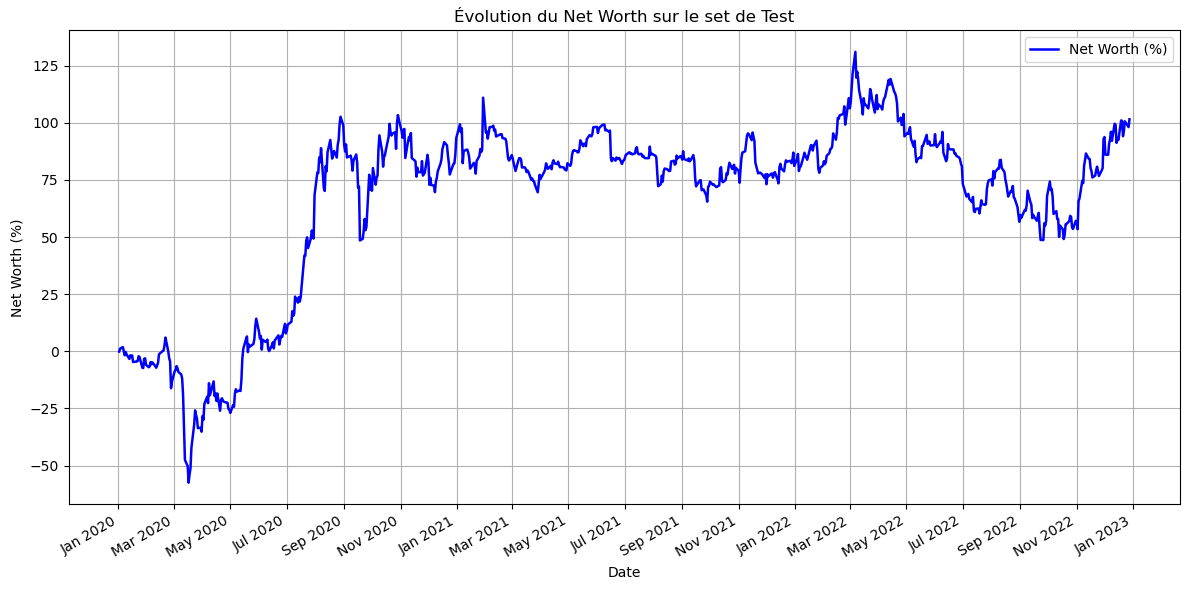

In [229]:
plot_net_worth(test_metrics=test_metrics, env=env_test)

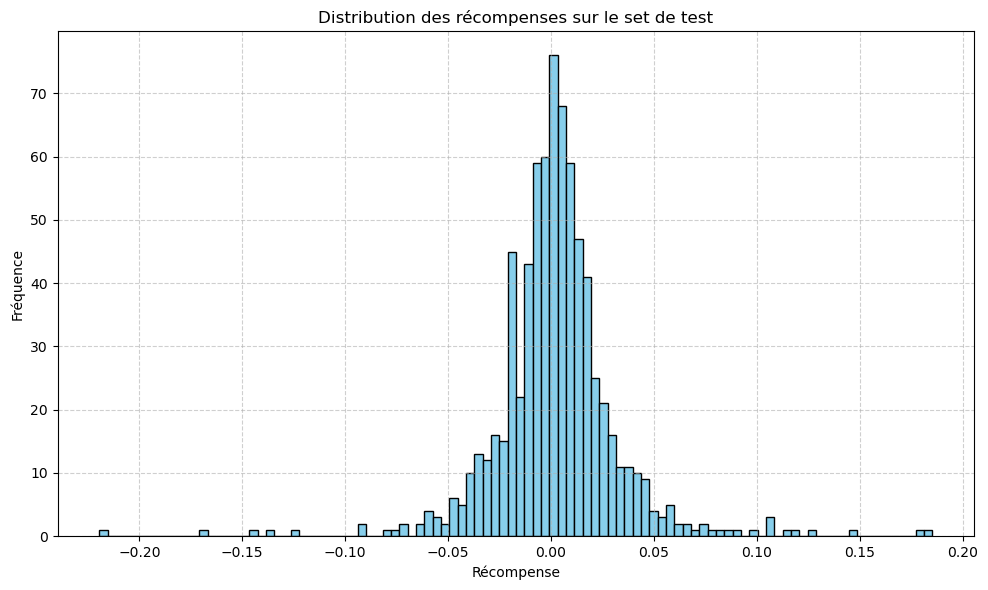

In [230]:
plot_reward_distribution(test_rewards)

ValueError: x and y must have same first dimension, but have shapes (30,) and (216,)

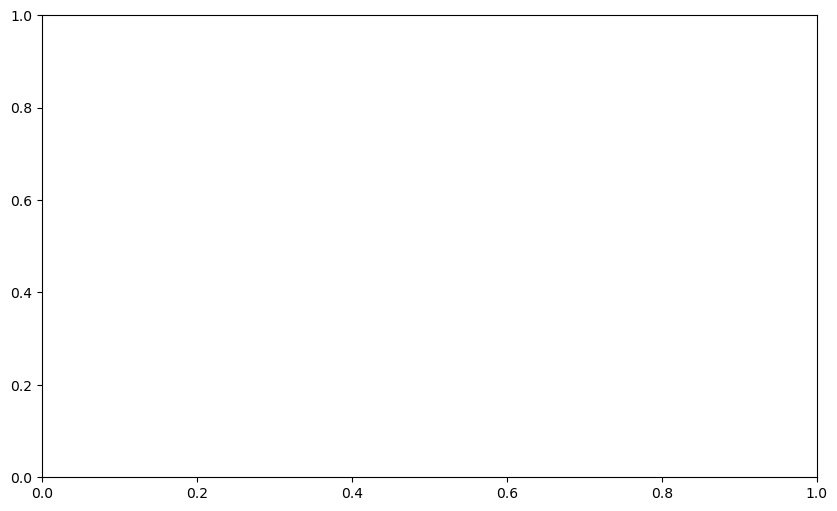

In [231]:
# Affichage des courbes de train losses
plot_losses(range(num_epochs), train_losses)

ValueError: x and y must have same first dimension, but have shapes (30,) and (60,)

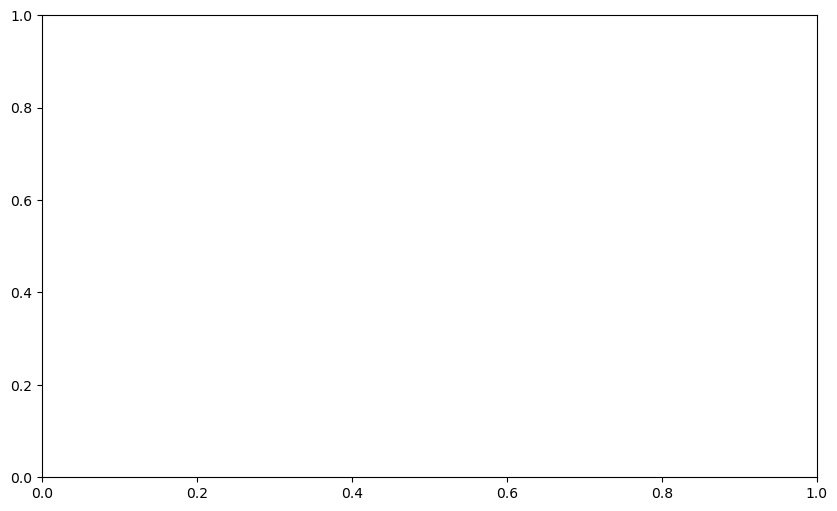

In [129]:
# Affichage des courbes de rewards (train vs validation)
plot_rewards(range(num_epochs), train_rewards, val_rewards)

C:\Users\planc\AppData\Local\Temp\ipykernel_13672\3871715114.py:199: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_norm = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])


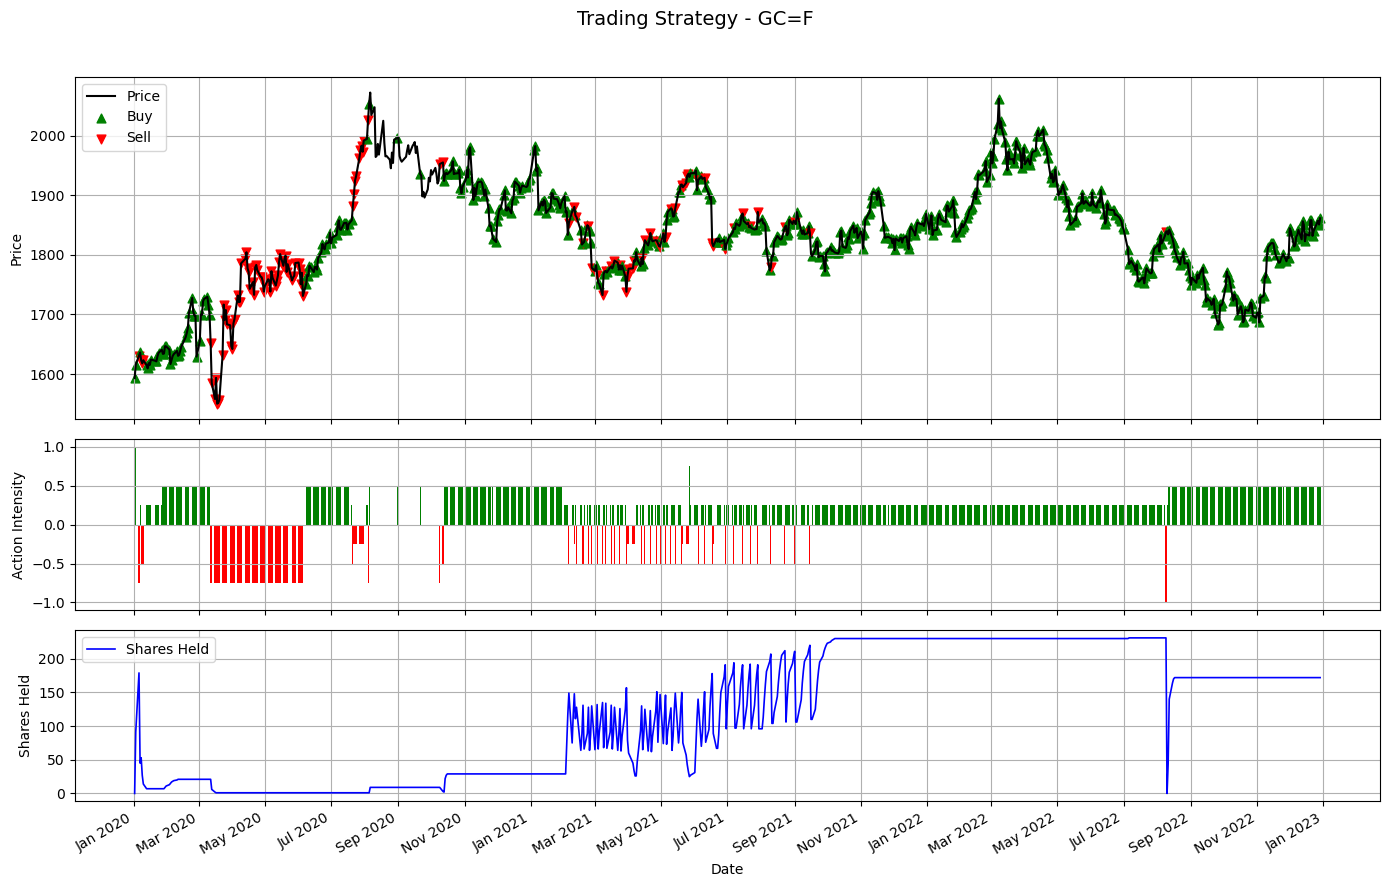

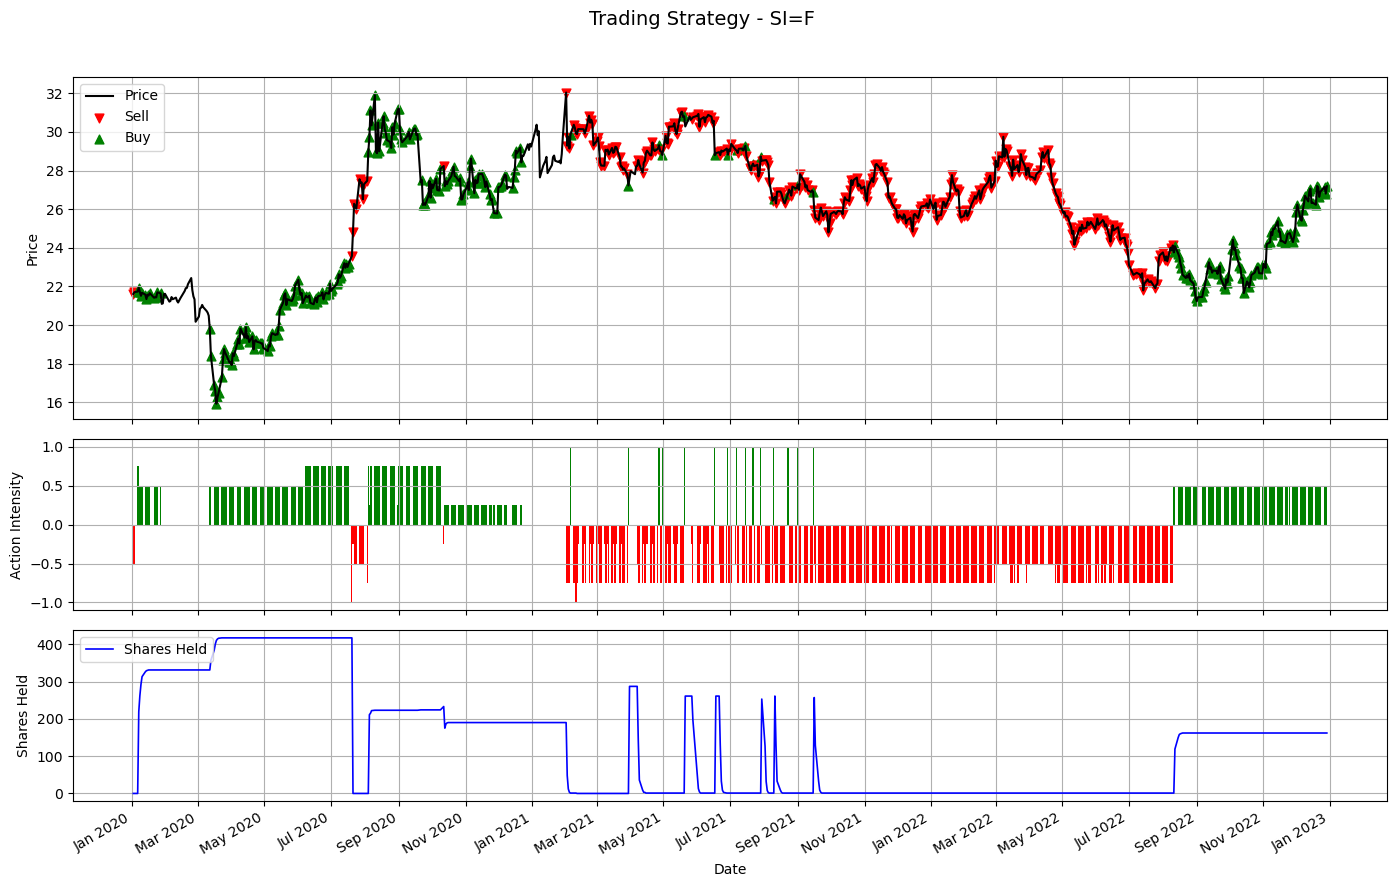

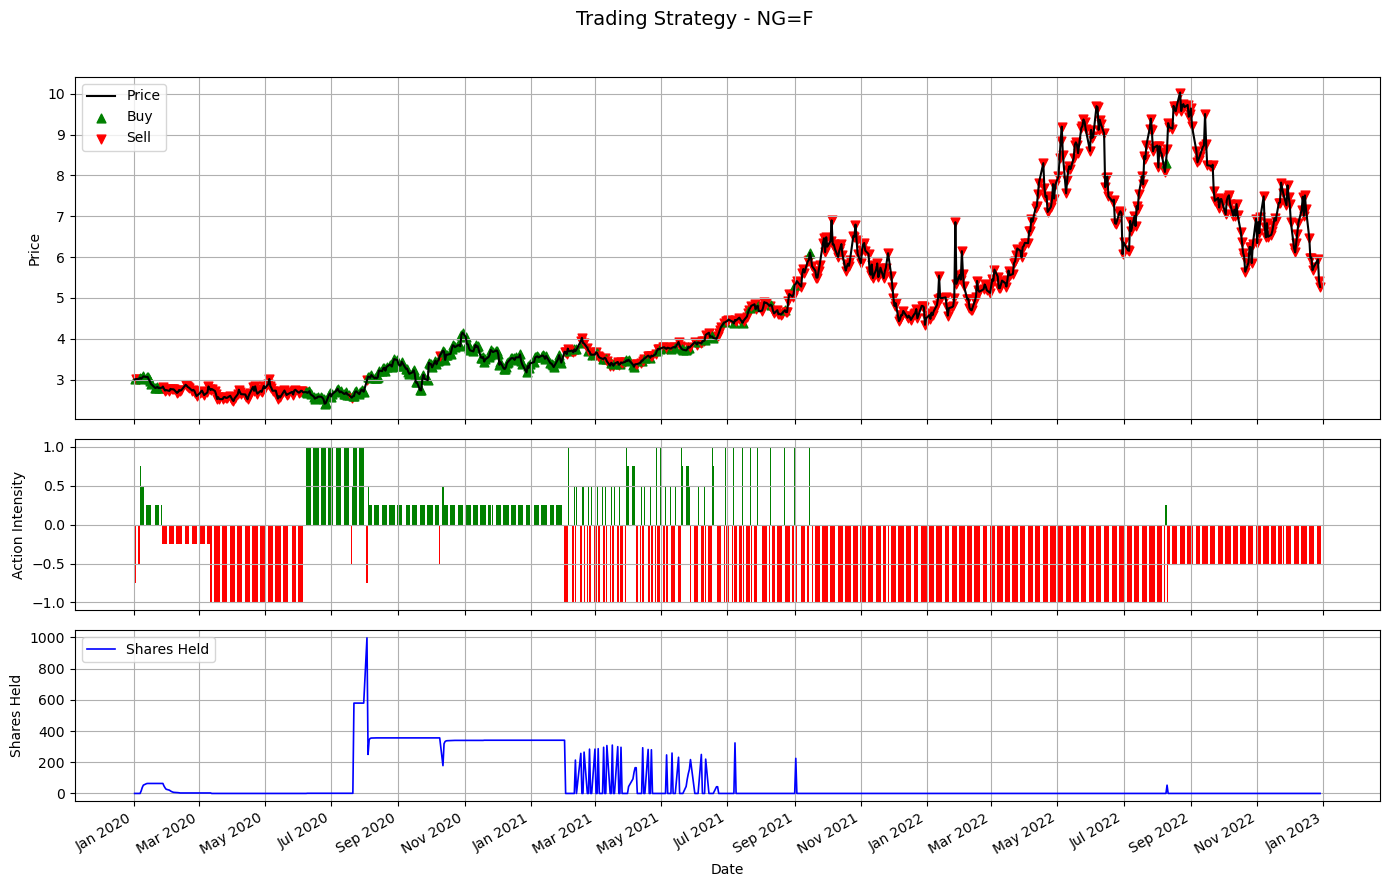

In [232]:
# Visualisation de la stratégie de trading sur le test set
nb_days = env_test.envs[0].max_steps
plot_trading_strategy(env_test, model, n_steps=nb_days)